# Загрузка библиотек и датасета

In [ ]:
! pip install -q opendatasets pandas numpy kaggle tensorflow matplotlib scikit-learn

In [ ]:
from google.colab import userdata
import os

from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Для запуска в google collab

In [ ]:
import os
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
! kaggle competitions download -c dl2025miptml

! unzip -o "dl2025miptml.zip"

Archive:  dl2025miptml.zip
  inflating: fashion-mnist-testn/fmnist_test.csv  
  inflating: fashion-mnist-testn/fmnist_train.csv  
  inflating: fashion-mnist-testn/sample_submission.csv  


In [ ]:
BASE_PATH = '/content/fashion-mnist-testn/'
train_df = pd.read_csv(f"{BASE_PATH}fmnist_train.csv")
test_df = pd.read_csv(f"{BASE_PATH}fmnist_test.csv")
sample_submission_df = pd.read_csv(f"{BASE_PATH}sample_submission.csv")

train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
test_df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [ ]:
sample_submission_df.head()

,Id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


# Предобработка данных

В данных есть пропуски, необходимо заполнить их, иначе модель не сможет обучиться. Заполним просто нулями, поскольку пропусков очень мало и 0 наиболее вероятое значение пикселя в данном датасете.

In [ ]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

# Сборка модели

In [ ]:
EPOCHS_COUNT = 200

def create_model():
  # у нас 784 признака что представляет собой картинку 28x28
  original_input_shape = (784, )
  # картинка ч/б поэтому цветовой канал 1
  input_shape = (28, 28, 1)

  model = keras.Sequential([
      # преобразуем размерность
      keras.layers.Reshape(input_shape, input_shape=original_input_shape),
      # набор сверточных слоев с регуляризацией
      keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=1, activation='relu', input_shape=input_shape),
      keras.layers.Dropout(0.3),
      keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='sigmoid'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Conv2D(filters=128, kernel_size=(4, 4), activation='relu'),
      keras.layers.Conv2D(filters=256, kernel_size=(6, 6), activation='relu'),
      keras.layers.Dropout(0.2),
      # полносвязные слои
      keras.layers.Flatten(),
      keras.layers.Dense(units=512),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(units=256, activation='relu'),
      keras.layers.Dense(units=128, activation='softsign'),
      keras.layers.Dropout(0.15),
      keras.layers.Dense(units=64, activation='relu'),
      keras.layers.Dense(units=32),
      keras.layers.Dense(units=10, activation='softmax')
  ])

  # задаем модели оптимизатор, функцию потерь и критерий для минимизации(accuracy)
  optimizer = SGD(learning_rate=0.0001, momentum=0.9)
  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

model = create_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,223,914 (23.74 MB)

 Trainable params: 6,223,914 (23.74 MB)

 Non-trainable params: 0 (0.00 B)

# Валидация модели

keras работает с numpy массивами. Для начала уберем признаки, которые не относятся к содержанию картинки, затем нормализуем значение пикселей до диапозона [0, 1].
Разделим тренировочный датасет на train и test части и используем one hot encoding для таргета.

In [ ]:
X = train_df.drop(columns=['label', 'Id']).copy(deep=True).values
y = train_df['label'].copy(deep=True).values

X = X / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

Обучим модель на тестовой выборке X_train и после каждой эпохи вычислим метрики на X_test.

In [ ]:
history = model.fit(
    X_train,
    y_train_one_hot,
    epochs=EPOCHS_COUNT,
    batch_size=64,
    validation_data=(X_test, y_test_one_hot)
)

Epoch 1/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.1038 - loss: 2.3086 - val_accuracy: 0.0951 - val_loss: 2.3025
Epoch 2/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0999 - loss: 2.3040 - val_accuracy: 0.0951 - val_loss: 2.2960
Epoch 3/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1107 - loss: 2.2988 - val_accuracy: 0.0951 - val_loss: 2.2945
Epoch 4/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1258 - loss: 2.2943 - val_accuracy: 0.0951 - val_loss: 2.2865
Epoch 5/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.1414 - loss: 2.2847 - val_accuracy: 0.1969 - val_loss: 2.2678
Epoch 6/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1801 - loss: 2.2693 - val_accuracy: 0.2785 - val_loss: 2.2449
Epoch 7/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2215 - loss: 2.2453 - val_accuracy: 0.3283 - val_loss: 2.1979
Epoch 8/200
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2549 - loss: 2.1974 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print(f'Test accuracy: {test_acc:.3f}')

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8443 - loss: 0.4051
Test accuracy: 0.834


Визуализируем обучение модели

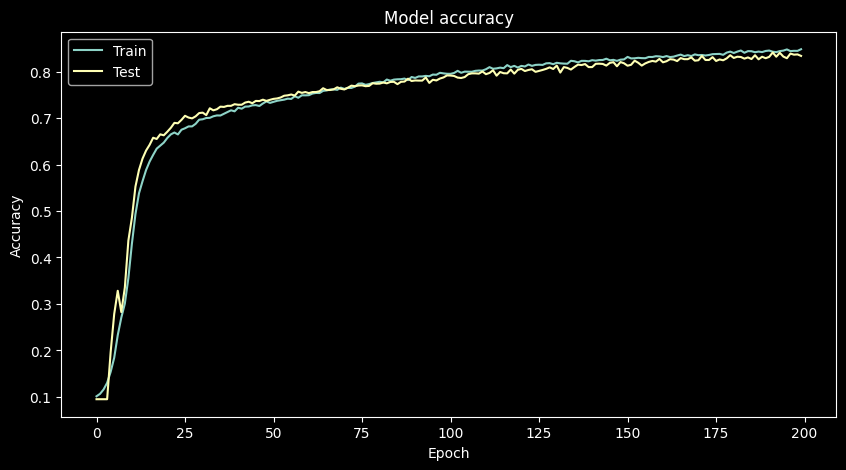

In [ ]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Обучение модели на всей обучающей выборке

После того, как мы убеделись в правильной работе модели на тренировочных данных нужно переобучить модель на всем тренировочном датасете, чтобы улучшить точность

In [ ]:
X_train = train_df.drop(columns=['label', 'Id']).copy(deep=True).values
y_train = train_df['label'].copy(deep=True).values

X_train = X_train / 255.0
y_train_one_hot = to_categorical(y_train)

In [ ]:
model = create_model()
model.fit(
    X_train,
    y_train_one_hot,
    epochs=EPOCHS_COUNT,
    batch_size=64,
);

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.1017 - loss: 2.3105
Epoch 2/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1177 - loss: 2.3006
Epoch 3/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1325 - loss: 2.2936
Epoch 4/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.1786 - loss: 2.2761
Epoch 5/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2431 - loss: 2.2495
Epoch 6/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2732 - loss: 2.1995
Epoch 7/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3066 - loss: 2.0897
Epoch 8/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3511 - loss: 1.9038
Epoch 9/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4287 - loss: 1.6814
Epoch 10/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5119 - loss: 1.4625
Epoch 11/200
267/267 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5570 - loss: 1.2864
Epoch 12/200
267/267 ━━━━━━━━

# Предсказания

Итак, теперь обученнная модель готова делать предсказание на валидационной выборке. Не забываем повторить предобработку данных, которую делали на тренировочном датасете.

In [ ]:
X_test_df = test_df.drop(columns=['Id']).copy(deep=True).values
X_test_df = X_test_df / 255.0

In [ ]:
predictions = model.predict(X_test_df)
predicted_classes = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


# Оформление submission.csv

In [ ]:
submition = pd.DataFrame(predicted_classes, columns=['label'])
submition = pd.DataFrame(predicted_classes, index=test_df['Id'], columns=['label'])
submition.index.name = 'Id'
submition.head()

,label
Id,
0,0
1,1
2,2
3,0
4,4


In [ ]:
submition = submition.reset_index()
submition.to_csv('submition.csv', index=False);

In [ ]:
!kaggle competitions submit dl2025miptml -f submition.csv -m "auto submission"

100% 67.3k/67.3k [00:00<00:00, 70.7kB/s]
Successfully submitted to Построение классификатора